In [1]:
!which python

/home/user/jfayzullaev/stellar-clustering/.venv-vis/bin/python


In [2]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [ ]:
LOUVAIN_CSV = "../louvain_result_res0.5.csv"

GRAPH_PKL   = "~/stellar-clustering/network/LCC/transactions/LCC_G_tx_undirected_weighted.pkl"

Any structural/community analysis (degree histograms, intra/inter-community edges, density, conductance, cut size, modularity components, centrality per community, connected components, etc.) requires the graph.
CSV = labels; PKL = network. You need both to analyze how communities behave on the graph.

In [4]:
df = pd.read_csv(LOUVAIN_CSV)

In [ ]:
if "account_id" not in df.columns and "node" in df.columns:
    df = df.rename(columns={"node": "account_id"})

In [6]:
with open(GRAPH_PKL, "rb") as f:
    G = pickle.load(f)

is the right representation for standard Louvain-style community analysis and avoids distortions from directionality or multi-edges.

In [ ]:
def coerce_ids_to_graph_type(series, G):
    sample_node = next(iter(G.nodes))
    if isinstance(sample_node, int):
        try:
            return series.astype(int)
        except Exception:
            pass
    return series.astype(str)

In [9]:
df["account_id"] = coerce_ids_to_graph_type(df["account_id"], G)

print(f"Original Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
print(df.head())

Original Graph: 206,451 nodes, 264,829 edges
   account_id  community  resolution
0   145489920          0         0.5
1    68681729          0         0.5
2      524290          0         0.5
3   145489921          0         0.5
4    68681737          0         0.5


### Top 5 communities in Louvian

In [10]:
community_sizes = df["community"].value_counts().sort_values(ascending=False)
top_5 = community_sizes.head(5)

print("Top 5 communities (by number of nodes in the Louvain CSV):")
display(top_5.to_frame(name="size_in_partition"))
print(f"\nTotal communities: {len(community_sizes)}")
print(f"Average community size: {community_sizes.mean():.2f}")

top_5_ids = top_5.index.tolist()
top_5_ids


Top 5 communities (by number of nodes in the Louvain CSV):


,size_in_partition
community,
0,69911
1,42429
2,37346
3,27366
4,11301



Total communities: 21
Average community size: 9831.00


[0, 1, 2, 3, 4]

#### Per community stats

In [ ]:
rows = []

for cid in top_5_ids:
    # nodes assigned to this community
    comm_nodes = set(df.loc[df["community"] == cid, "account_id"])
    # intersect with actual graph nodes
    comm_nodes_in_G = [n for n in comm_nodes if n in G]
    
    sub = G.subgraph(comm_nodes_in_G).copy()
    n_nodes = sub.number_of_nodes()
    n_edges = sub.number_of_edges()
    density = nx.density(sub) if n_nodes > 1 else 0.0
    degrees = dict(sub.degree())
    avg_degree = (sum(degrees.values()) / n_nodes) if n_nodes > 0 else 0.0
    
    rows.append({
        "community": cid,
        "size_in_partition (nodes)": len(comm_nodes),
        "size_in_graph": n_nodes,
        "edges_in_graph": n_edges,
        "density": density,
        "avg_degree": avg_degree
    })

top5_stats = pd.DataFrame(rows).sort_values("size_in_graph", ascending=False)
display(top5_stats)


,community,size_in_partition (nodes),size_in_graph,edges_in_graph,density,avg_degree
0,0,69911,69911,69989,0.000029,2.002231
1,1,42429,42429,42440,0.000047,2.000519
2,2,37346,37346,37345,0.000054,1.999946
3,3,27366,27366,42502,0.000114,3.106190
4,4,11301,11301,16483,0.000258,2.917087


#### Plot the Degree Distribution for top 5 

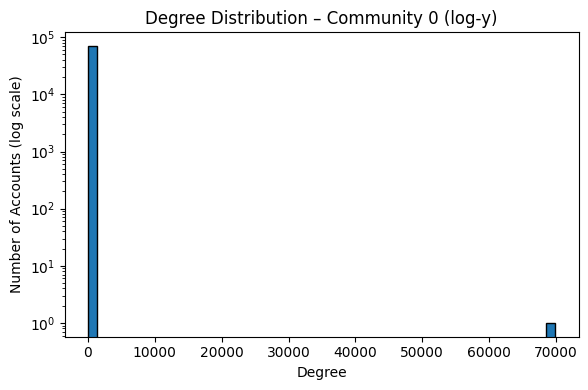

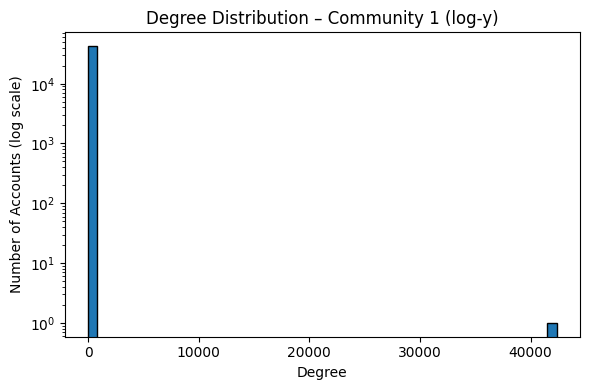

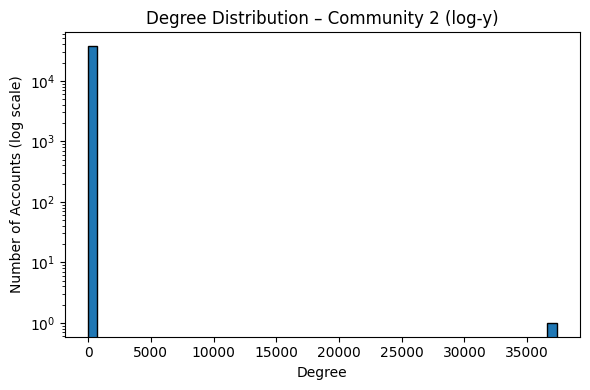

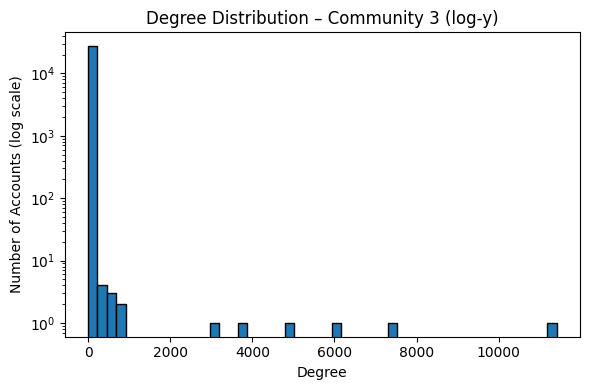

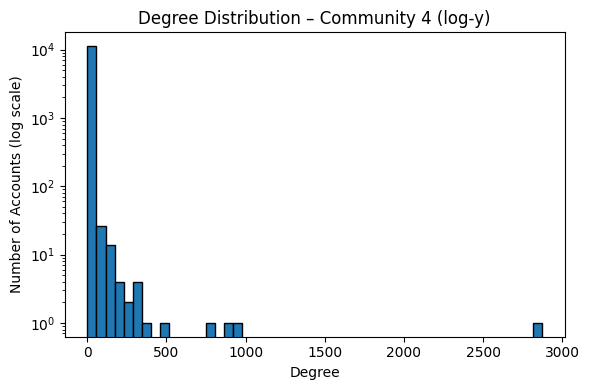

In [12]:
for community_id in top_5_ids:
    comm_nodes = df.loc[df["community"] == community_id, "account_id"]
    comm_nodes_in_G = [n for n in comm_nodes if n in G]
    sub = G.subgraph(comm_nodes_in_G)
    
    degs = [d for _, d in sub.degree()]
    if len(degs) == 0:
        print(f"Community {community_id}: no nodes in graph, skipping plot.")
        continue

    plt.figure(figsize=(6, 4))
    plt.hist(degs, bins=50, log=True, edgecolor='black')
    plt.title(f"Degree Distribution – Community {community_id} (log-y)")
    plt.xlabel("Degree")
    plt.ylabel("Number of Accounts (log scale)")
    plt.tight_layout()
    plt.show()


### Bind To Metadata

In [13]:
NODES_CSV   = "~/stellar-clustering/network/data/new/account_nodes_all_mv.csv"
FEATS_CSV   = "~/stellar-clustering/network/data/new/account_node_features_full_mv.csv"

In [1]:
df_nodes = pd.read_csv(NODES_CSV)
df_meta  = pd.read_csv(FEATS_CSV)

NameError: name 'pd' is not defined

In [ ]:
df_comm = df.rename(columns={'node': 'account_id'})

df_merged = df_comm.merge(df_meta, on='account_id', how='left')

print(df_merged.head(10))

   account_id  community  resolution  \
0   145489920          0         0.5   
1    68681729          0         0.5   
2      524290          0         0.5   
3   145489921          0         0.5   
4    68681737          0         0.5   
5   162791434          0         0.5   
6   162791435          0         0.5   
7   162791433          0         0.5   
8   162791438          0         0.5   
9   145489936          0         0.5   

                                             address      balance  \
0  GDSVCRHN3QHRXW3AW6NSIBLK7RIFAL3MQSSGSU4ZUGETDN...      28576.0   
1  GCGH5D2YHJSYJCF7SCJ7Y56JJKPILTZEYHGIUR4LKR3MGT...      17850.0   
2  GAZGB6WJZBGMLGVXLC35MKM5XOKSYUQMM6SBBGCIL37TI7...  795945706.0   
3  GAVDZNXYLLTSCYKMJHQ3IQPQJKWHZMXF4PMIKHT6EP7JZ5...          0.0   
4  GC37NIMXQVUVFEJ5TPS6CS7DZSKJY7TZR5A5VTZMSXMRI2...          0.0   
5  GD3IKFGLERQMCDHGL4H6W3MRQSBHZETOLATF4BTUYUXPYW...          0.0   
6  GDKMNG3DWQ3XSZUKQKTWRGWN2GAQETXJFLVJDTOYD6A5O2...          0.0   
7  GAOJ

In [ ]:
df_with_metadata = df_merged[df_merged['address'].notnull()]
overlap = df_comm['account_id'].isin(df_meta['account_id']).sum()

Louvain + metadata for all accounts

account_node_features_mv.csv and louvain_result_res0.8.csv by internal ids

Connect Graph Communities to Real-World Accounts

In [19]:
output_path = "lcc-louvian0.5-metadata.csv"
df_with_metadata.to_csv(output_path, index=False)

print(f"\nSaved {len(df_with_metadata)} records with metadata ({len(df_with_metadata)/len(df_merged)*100:.2f}%) to: {output_path}")



Saved 206451 records with metadata (100.00%) to: lcc-louvian0.5-metadata.csv


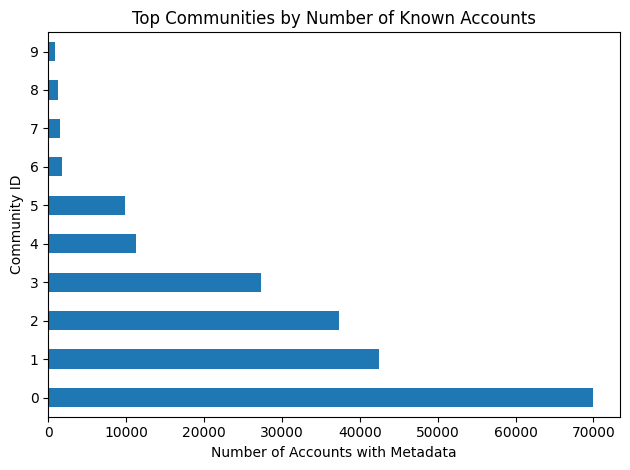

In [20]:
df_with_metadata['community'].value_counts().head(10).plot(kind='barh', title='Top Communities by Number of Known Accounts')
plt.xlabel("Number of Accounts with Metadata")
plt.ylabel("Community ID")
plt.tight_layout()
plt.show()


### Bind with the normalized labels 

In [21]:
NORM_LABELS = "../../labels/label-normalization/labels_entities_normalized.csv"

In [22]:
df_norm = (pd.read_csv(NORM_LABELS)
             .dropna(subset=["account_id","name"])
             .drop_duplicates(subset=["account_id"])
             .rename(columns={"name":"entity"}))

In [ ]:
try:
    df_comm["account_id"] = df_comm["account_id"].astype("Int64")
    df_norm["account_id"] = df_norm["account_id"].astype("Int64")
except Exception:
    df_comm["account_id"] = df_comm["account_id"].astype(str)
    df_norm["account_id"] = df_norm["account_id"].astype(str)


In [24]:
df_matched = df_comm.merge(df_norm, on="account_id", how="inner")

print(f"Matched normalized-labeled accounts: {len(df_matched):,} / {len(df_comm):,} "
      f"({len(df_matched)/len(df_comm):.2%})")
df_matched.head()

Matched normalized-labeled accounts: 397 / 206,451 (0.19%)


,account_id,community,resolution,entity
0,1369781,0,0.5,SCAM
1,6362039,0,0.5,SCAM
2,621481,0,0.5,SCAM
3,157479,0,0.5,SCAM
4,8555239,0,0.5,SCAM


Top communities with the most normalized-labeled accounts

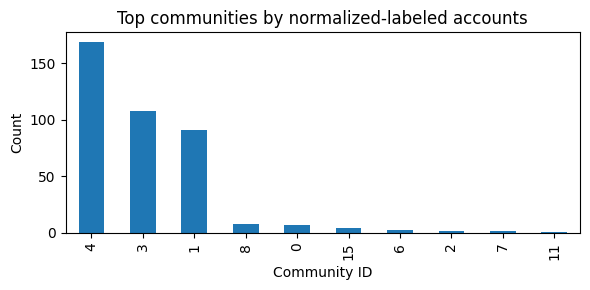

In [25]:
top_counts = df_matched["community"].value_counts().head(10)
ax = top_counts.plot(kind="bar", figsize=(6,3), title="Top communities by normalized-labeled accounts")
ax.set_xlabel("Community ID"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()


The largest communities by size (e.g., 0 and 2) have very few labels.

How many normalized-labeled addresses (per entity) in each community

within the labeled subset only inside a community, which entity appears most and with what share.

In [ ]:
label_counts = (df_matched
                .groupby(["community","entity"])
                .size().reset_index(name="count"))

top_communities = (label_counts.groupby("community")["count"]
                   .sum().sort_values(ascending=False)
                   .head(5).index.tolist())

for cid in top_communities:
    print(f"\nCommunity {cid} — normalized entity breakdown:")
    display(label_counts[label_counts["community"]==cid]
            .sort_values("count", ascending=False))



Community 4 — normalized entity breakdown:


,community,entity,count
48,4,SCAM,110
32,4,Coinbase,16
21,4,Binance,6
33,4,EXLM,3
26,4,Blockchain.com,3
24,4,Bitpanda,2
41,4,Lobstr,2
29,4,Centre,2
51,4,Upbit,2
28,4,CEX.IO,1



Community 3 — normalized entity breakdown:


,community,entity,count
18,3,SCAM,104
19,3,UltraCapital,3
20,3,montelibero.org,1



Community 1 — normalized entity breakdown:


,community,entity,count
11,1,SCAM,48
5,1,Coinbase,16
12,1,SDF,11
15,1,Wirex,3
2,1,AQUA,2
4,1,Burn Account,1
3,1,AnchorUSD,1
1,1,AADC,1
8,1,NaoBTC,1
7,1,EXMO,1



Community 8 — normalized entity breakdown:


,community,entity,count
56,8,SCAM,8



Community 0 — normalized entity breakdown:


,community,entity,count
0,0,SCAM,7


Dominant entity & purity (on the labeled subset), plus community size

In [ ]:
tot = label_counts.groupby("community")["count"].sum().rename("cnt_total")

dom = (label_counts.sort_values(["community","count"])
                 .groupby("community").tail(1)
                 .rename(columns={"entity":"dominant_entity","count":"dominant_cnt"})
                 .set_index("community"))

size_all = df_comm.groupby("community").size().rename("size_in_partition")

summary = (dom.join(tot, how="left")
             .join(size_all, how="left"))
summary["purity_labeled"] = summary["dominant_cnt"] / summary["cnt_total"]
summary = summary.reset_index()


summary.sort_values("size_in_partition", ascending=False).head(10)

# Community ID

# Dominant entity

# Dominant count (number of accounts from that entity) number of labeled accounts belonging to the dominant_entity in this community.

# Total labeled accounts in that community

# Total size of the community in Louvain

# Purity on labeled subset = dominant_count / total_labeled.


,community,dominant_entity,dominant_cnt,cnt_total,size_in_partition,purity_labeled
0,0,SCAM,7,7,69911,1.000000
1,1,SCAM,48,91,42429,0.527473
2,2,SCAM,2,2,37346,1.000000
3,3,SCAM,104,108,27366,0.962963
4,4,SCAM,110,169,11301,0.650888
5,6,SCAM,2,3,1759,0.666667
6,7,SCAM,2,2,1464,1.000000
7,8,SCAM,8,8,1274,1.000000
8,11,SCAM,1,1,647,1.000000
9,12,Syklo,1,1,497,1.000000


how much of each community is labeled and how much of the labeled dataset each community covers.

In [ ]:
total_labels = len(df_matched) 
summary["label_coverage"] = summary["cnt_total"] / summary["size_in_partition"]
summary["labeled_share"]   = summary["cnt_total"] / total_labels
summary.sort_values(["labeled_share","purity_labeled"], ascending=False).head(10)


,community,dominant_entity,dominant_cnt,cnt_total,size_in_partition,purity_labeled,label_coverage,labeled_share
4,4,SCAM,110,169,11301,0.650888,0.014954,0.425693
3,3,SCAM,104,108,27366,0.962963,0.003947,0.272040
1,1,SCAM,48,91,42429,0.527473,0.002145,0.229219
7,8,SCAM,8,8,1274,1.000000,0.006279,0.020151
0,0,SCAM,7,7,69911,1.000000,0.000100,0.017632
10,15,TMM bot,4,4,217,1.000000,0.018433,0.010076
5,6,SCAM,2,3,1759,0.666667,0.001706,0.007557
2,2,SCAM,2,2,37346,1.000000,0.000054,0.005038
6,7,SCAM,2,2,1464,1.000000,0.001366,0.005038
8,11,SCAM,1,1,647,1.000000,0.001546,0.002519


In [29]:
df_matched.to_csv("louvain_res0.5_with_normalized_labels.csv", index=False)
print("Saved louvain_res0.5_with_normalized_labels.csv")


Saved louvain_res0.5_with_normalized_labels.csv


In [ ]:
entity_col = "entity"

assert {"account_id","community",entity_col}.issubset(df_matched.columns), "Missing required columns"

print(f"Labeled rows used for eval: {len(df_matched):,}")


Labeled rows used for eval: 397


Per-community purity + overall weighted purity. 

Entity Purity Analysis of Louvain Communities (based on normalized labels)

In [ ]:
# Inside each Louvain community, are the labeled accounts mostly from one real-world entity

label_counts = (
    df_matched
    .groupby(["community", entity_col])
    .size()
    .reset_index(name="count")
)

tot_labeled = label_counts.groupby("community")["count"].sum().rename("total_labeled")

dom = (
    label_counts
    .sort_values(["community","count"])
    .groupby("community")
    .tail(1)
    .rename(columns={entity_col:"dominant_entity", "count":"dominant_cnt"})
    .set_index("community")
)


df_purity = (
    dom.join(tot_labeled, how="left")
)
df_purity["purity"] = df_purity["dominant_cnt"] / df_purity["total_labeled"]
df_purity = df_purity.reset_index()

overall_weighted_purity = np.average(df_purity["purity"], weights=df_purity["total_labeled"])
print(f"Overall weighted purity (normalized labels): {overall_weighted_purity:.3f}")

display(df_purity.sort_values(["purity","total_labeled"], ascending=[False, False]).head(10))


Overall weighted purity (normalized labels): 0.730


,community,dominant_entity,dominant_cnt,total_labeled,purity
7,8,SCAM,8,8,1.000000
0,0,SCAM,7,7,1.000000
10,15,TMM bot,4,4,1.000000
2,2,SCAM,2,2,1.000000
6,7,SCAM,2,2,1.000000
8,11,SCAM,1,1,1.000000
9,12,Syklo,1,1,1.000000
11,20,Lobstr,1,1,1.000000
3,3,SCAM,104,108,0.962963
5,6,SCAM,2,3,0.666667
